<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_Classifier_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os import listdir
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import files
files.upload() 

In [ ]:
import CreatePestImageData as Imagedataset
import SupportingFunctions as support

In [ ]:
support.DownLoadFiles('1aXb25Wp9sG7mL6AQgYY9ElrGcERi95JU',drive)

In [ ]:
support.Unzip('/content/GREENPATROL_DB_V3.0.zip','/content/Pests/Images')

In [ ]:
support.fileCount('/content/Pests/Images')

4330


In [ ]:
dataSet = Imagedataset.createImageDataset()

In [ ]:
class_object = {0 : 'egg_wf' ,
                1 : 'egg_bt', 2 : 'egg_ta', 3 : 'wf', 4 : 'bt', 5 : 'tomato'}

In [ ]:
dataSet.prepare_dataset('/content/Pests/Labels' , class_object , 75 , '/content/Pests/Images',  test_size=11241 )

In [ ]:
listdir('/content/Pests/Labels')

In [ ]:
(trainY , trainX) , (testY , testX ) = (dataSet.trainY , dataSet.trainX ) , (dataSet.testY , dataSet.testX )


In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from keras import backend as K
if K.image_data_format() == 'channels_first':
   input_shape = [3, 75, 75]
else:
   input_shape = [75, 75, 3]

In [ ]:
import tensorflow as tf
from keras import models
from keras.applications.xception import Xception
Xception = Xception(input_shape=input_shape, include_top=False, pooling='avg',weights='imagenet')
Xception.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 37, 37, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 37, 37, 32)   0           block1_conv1_bn[0][0]            
__________________________

In [ ]:
from keras.models import Model
layerName = 'block1_conv2'
mymodel = Model(inputs= Xception.input , outputs=Xception.get_layer(layerName).output)
mymodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 37, 37, 32)        864       
_________________________________________________________________
block1_conv1_bn (BatchNormal (None, 37, 37, 32)        128       
_________________________________________________________________
block1_conv1_act (Activation (None, 37, 37, 32)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 35, 35, 64)        18432     
Total params: 19,424
Trainable params: 19,360
Non-trainable params: 64
_________________________________________________________________


In [ ]:
from keras import applications
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

In [ ]:
model= models.Sequential()
model.add(mymodel)
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))
model.layers[0].trainable = True

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 35, 35, 64)        19424     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 35, 35, 16)        9232      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [ ]:
from tensorflow.keras.utils import to_categorical
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [ ]:
filepath="/content/drive/My Drive/Models/Xception/weights-{epoch:02d}-{accuracy:.3f}.hdf5"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='accuracy',
                               verbose=1, mode='max',save_best_only=True)

callbacks_list = [checkpoint]

In [ ]:
tf.config.experimental_run_functions_eagerly(True)


In [ ]:
from keras.models import load_model
model_Saved = load_model("/content/drive/My Drive/Models/Xception/weights-43-0.732.hdf5")
model_Saved.fit(trainX, trainY,  epochs=50,verbose=1,
                           validation_data=(testX, testY),
                          callbacks=callbacks_list)

Train on 44964 samples, validate on 11241 samples
Epoch 1/50
44964/44964 [==============================] - 60s 1ms/step - loss: 0.6478 - accuracy: 0.7326 - val_loss: 0.8304 - val_accuracy: 0.6887

Epoch 00001: accuracy improved from -inf to 0.73256, saving model to /content/drive/My Drive/Models/Xception/weights-01-0.733.hdf5
Epoch 2/50
44964/44964 [==============================] - 59s 1ms/step - loss: 0.6436 - accuracy: 0.7336 - val_loss: 0.7177 - val_accuracy: 0.7106

Epoch 00002: accuracy improved from 0.73256 to 0.73356, saving model to /content/drive/My Drive/Models/Xception/weights-02-0.734.hdf5
Epoch 3/50
44964/44964 [==============================] - 59s 1ms/step - loss: 0.6401 - accuracy: 0.7350 - val_loss: 0.7349 - val_accuracy: 0.7106

Epoch 00003: accuracy improved from 0.73356 to 0.73499, saving model to /content/drive/My Drive/Models/Xception/weights-03-0.735.hdf5
Epoch 4/50
44964/44964 [==============================] - 58s 1ms/step - loss: 0.6388 - accuracy: 0.7342 - 

In [ ]:
import json
history_dict = model_Saved.history.history
json.dump(str(history_dict), open('/content/drive/My Drive/Models/Xception/History/Xception_History1.json', 'w'))

In [ ]:
acc = model_Saved.history.history['accuracy']
val_accuracy = model_Saved.history.history['val_accuracy']
loss  =  model_Saved.history.history['loss']
val_loss = model_Saved.history.history['val_loss']

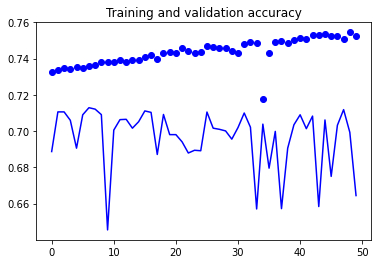

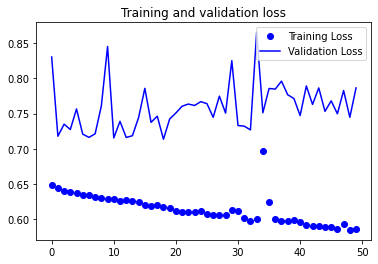

In [ ]:
support.GenerateGraphs(acc,val_accuracy,loss,val_loss)

In [ ]:
support.PrintMetrics(testX_Pred,testY_Pred,model_Saved)

Accuracy: 0.664443
Precision: 0.676403
Recall: 0.658654
F1 score: 0.665604
Cohens kappa: 0.502655
